to-do
- create a dataset of images and tag them as is_big_flare - true or false
  - the dataset will be a df where each row reperesents an image and columns will be datetime, image_pixels_nparrayjson,  is_big_flare

# SDO Machine Learning (SDO ML) Dataset

In this notebook we demonstrate the process for interacting with a small sample of the SDO ML dataset.

*Meng Jin, Mark Cheung, & Paul Wright*

---

## Introduction

### SDO Overview

Since its launch in 2010, NASA’s Solar Dynamics Observatory (SDO; ([Pesnell et al. 2012](https://ui.adsabs.harvard.edu/abs/2012SoPh..275....3P/abstract)) has continuously monitored Sun's activity, delivering a wealth of valuable scientific data for heliophysics researchers with the use of three instruments:

1. The Atmospheric Imaging Assembly (AIA; [Lemen et al. 2012](https://ui.adsabs.harvard.edu/abs/2012SoPh..275...17L/abstract)), which captures 4096 x 4096 resolution images (with 0.6 arcsecond pixel size) of the full Sun in two ultraviolet (centered at 1600, and 1700 Å), seven extreme ultraviolet (EUV; centered at 94, 131, 171, 193, 211, 304, and 335 Å), and one visible (centered at 4500 Å) wavelength band.


2. The Helioseismic and Magnetic Imager (HMI; [Schou et al. 2012](https://ui.adsabs.harvard.edu/abs/2012SoPh..275..229S/abstract)) captures visible wavelength filtergrams of the full Sun at 4096 x 4096 resolution (a pixel size of 0.5 arcsecond), which are then processed into a number of data products, including photospheric Dopplergrams, line-of-sight magnetograms, and vector magnetograms ([Hoeksema et al. 2014](https://ui.adsabs.harvard.edu/abs/2014SoPh..289.3483H/abstract)).


3. The EUV Variability Experiment (EVE; [Woods et al. 2012](https://ui.adsabs.harvard.edu/abs/2012SoPh..275..115W/abstract)) monitors the solar EUV spectral irradiance from 1 to 1050 Å. This is done by utilizing multiple EUV Grating Spectrographs (MEGS) that disperse EUV light from the full disk of the Sun and its corona onto a 1024 x 2048 charge coupled device (CCD).

<img src="https://github.com/spaceml-org/helionb-sdoml/blob/main/notebooks/01_sdoml_dataset_2018/spacecraft_detailed.png?raw=1" width="400">

**Figure 1:** The Solar Dynamics Observatory (SDO) spacecraft, shown with the three main instruments (AIA, EVE, and HMI) highlighted. Image courtesy of NASA (https://sdo.gsfc.nasa.gov).

### The SDO ML Dataset
The SDO ML Dataset (covering 2010 - 2018) was originally published as [Galvez et al (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJS..242....7G/abstract), and is hosted on the Stanford Digital Repository in Numpy's compressed array format (.npz).

In this notebook, we present an update to the work outlined in Galvez et al (2019), in which the full dataset has been converted to cloud friendly Zarr format. Specifically, SDO/AIA data has been updated to account for a change in calibration after 2019. In addtion to the change in calibration, this updated format includes:

1. FITS header/keyword information (such as observation time, and exposure time).

2. processes for continually updating the data until the present day.

### Who is the SDO ML Dataset for?

The sheer volume of structured scientific data recorded by SDO (over 18 PB, and counting) is ideal for a range machine learning tasks (from time-series, to computer vision), as well as more traditional approaches.

While the level 1 data are easily accessible, pre-processing these data for scientific analysis often requires  specialized heliophysics (and instrument-specific) knowledge. This may act as an unnecessary hurdle for non-heliophysics machine learning researchers who may wish to experiment with datasets from the physical sciences, but are unaware of domain-specific nuances (e.g., that images must be spatially and temporally adjusted).

This notebook demonstrates the process for interacting with a subset of the curated SDO (AIA, HMI, EVE) dataset, that is mission-ready for machine-learning applications. **Our aim is to supply this standardized dataset for heliophysicists who wish to use machine learning in their own research, as well as machine-learning researchers who wish to develop models specialized for the physical sciences.**

---

## Table of Contents

The notebook is set out as follows:

1. Setting up the notebook
2. Reading and loading the data <br>
2a. Selecting images based on header information <br>
    2b. Selecting a subset of the data based on index <br>
    2c. Downsampling the data (resolution)<br>
    2d. Downsampling the data (temporally)<br>
3. Generating a SunPy map
4. Animating AIA data
5. Reading and loading HMI data
6. Reading and loading EVE data

## 1. Setting up the notebook

In [14]:
# use this pip install command to install all the necessary packages in your conda environment
#pip install zarr "sunpy[all]" s3fs

In [15]:
# %matplotlib inline

import os
from typing import Union
import zarr

# import gcsfs
import s3fs
import sunpy.map

import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import sunpy.visualization.colormaps as cm

from astropy.time import Time
from dask.distributed import Client, LocalCluster
from sunpy.visualization import axis_labels_from_ctype, wcsaxes_compat

from matplotlib import animation
from IPython.display import HTML

In [16]:
# fix dask cache size

from dask.cache import Cache
cache = Cache(1e9)  # Leverage 1 GB of memory
cache.register()    # Turn cache on globally

In [17]:
# AWS_ZARR_ROOT = (
#     "s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_small.zarr/"
# )

AWS_ZARR_ROOT = (
    "s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2.zarr/2015/"
)

def s3_connection(path_to_zarr: os.path) -> s3fs.S3Map:
    """
    Instantiate connection to aws for a given path `path_to_zarr`
    """
    return s3fs.S3Map(
        root=path_to_zarr,
        s3=s3fs.S3FileSystem(anon=True),
        # anonymous access requires no credentials
        check=False,
    )


def load_single_aws_zarr(
    path_to_zarr: os.path,
    cache_max_single_size: int = None,
) -> Union[zarr.Array, zarr.Group]:
    """
    load zarr from s3 using LRU cache
    """
    return zarr.open(
        zarr.LRUStoreCache(
            store=s3_connection(path_to_zarr),
            max_size=cache_max_single_size,
        ),
        mode="r",
    )

## 2. Reading and loading the AIA data


The SDO ML dataset is stored in the Zarr format, a format for the storage of chunked, compressed, N-dimensional arrays with Numpy dtype. For an in-depth overview, see https://zarr.readthedocs.io/en/stable/tutorial.html.

In [18]:
# first, we create a group with the store data located on GCP.
root = load_single_aws_zarr(
    path_to_zarr=AWS_ZARR_ROOT,
)

In [19]:
# Using `root.tree()`, we are able to display the hierarchy (of `loc`).
# print(root.tree())

As shown in the tree, the heirachy consists of groups, each shown with their respective shape, and data type. In this example, we will primarily look at the 171 Å channel from 2010. This consists of 6135 512x512 images, stored as float32, and can be accessed as follows:

In [20]:
images_171a_zarray = root["171A"]

We could have alternatively accessed the 2010 data as:

```
loc = 'fdl-sdoml-v2/sdomlv2_small.zarr/2010'
```

which becomes increasingly useful in the full dataset (where the heirachy contains years 2010 - present).

**Loading with Dask**

We can then load this data into an array using dask.

In [21]:
all_image = da.from_array(images_171a_zarray)
all_image

dask.array<array, shape=(82806, 512, 512), dtype=float32, chunksize=(120, 512, 512), chunktype=numpy.ndarray>

As shown above, the data has the shape (6135, 512, 512), and is split into 52 chunks of (120, 512, 512), each of 125.83 MB; this is further visualised on the right. The data is now in a form to be manipulated like a Numpy array.

We can load and display one image now:

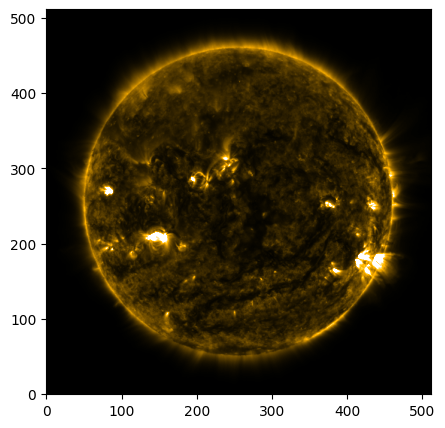

In [22]:
image=all_image[0,:,:]
plt.figure(figsize=(5,5))
colormap = plt.get_cmap('sdoaia171')
plt.imshow(image.compute(),origin='lower',vmin=10,vmax=1000,cmap=colormap)

Depending on the use-case, we may wish to extract a subset of this data in various ways. In the following sections we step through a number of potential operations that we may wish to make with the data.

### 2a. Selecting images based on header information

The new data includes all fits header information with the same keywords. To find out the AIA keyword definition, one can refer to the following online document:
http://jsoc.stanford.edu/~jsoc/keywords/AIA/AIA02840_K_AIA-SDO_FITS_Keyword_Document.pdf

And one can list all the AIA keywords included:

We can extract the exposure (and observation) time from the data attributes (the header information), and downsample our data based upon that information.

### 2b. Selecting images based on indices

While the data is not currently ordered by observation time, we can simple index the array to extract a number of observations

In [23]:
# We are going to choose data in 1 hour intervals


# df_time = pd.DataFrame(t_obs, index=np.arange(np.shape(t_obs)[0]), columns=["Time"])
# df_time["Time"] = pd.to_datetime(df_time["Time"])

# select times at a frequency of 60 minutes
wanted_times = pd.date_range(
    start="2015-01-01 00:00:00", end="2015-12-31 23:59:59", freq="60T", tz="UTC"
)

In [24]:
# select subset of images based on time

images_zry_wanted_idxs = []
images_zry_times = pd.to_datetime(np.array(images_171a_zarray.attrs["T_OBS"]))
for selected_time in wanted_times[None:None]:
    images_zry_wanted_idxs.append(np.argmin(abs(images_zry_times - selected_time)))

# removing dupes from images_zry_wanted_idxs
images_zry_wanted_idxs = sorted(set(images_zry_wanted_idxs))

# get wanted times and wanted images
images_wanted_times = images_zry_times[images_zry_wanted_idxs]
images_wanted_drry = da.from_array(images_171a_zarray)[images_zry_wanted_idxs, :, :]

# after selecting images via time_index, we wan to downsample in resolution
# downsample the data to 256 by sampling every other pixel
downsampled_pxl_posns = np.arange(0, 512, 2)
images_wanted_drry = images_wanted_drry[:, downsampled_pxl_posns, :][:, :, downsampled_pxl_posns]

# visualize the data at images_zry_wanted_idxs
print("images_zry_wanted_idxs = ", images_zry_wanted_idxs)
print("len(images_wanted_times) = ", len(images_wanted_times))
images_wanted_drry

images_zry_wanted_idxs =  [0, 10, 20, 30, 40, 50, 60, 61, 64, 73, 83, 93, 103, 113, 123, 133, 143, 153, 163, 173, 183, 192, 202, 212, 222, 232, 242, 252, 262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382, 392, 402, 412, 422, 431, 441, 451, 461, 471, 481, 491, 501, 511, 521, 523, 525, 534, 544, 554, 564, 574, 584, 594, 604, 614, 624, 634, 644, 653, 663, 673, 683, 693, 703, 713, 723, 733, 743, 745, 753, 762, 772, 782, 792, 802, 812, 822, 832, 842, 852, 862, 872, 881, 891, 901, 911, 921, 931, 941, 951, 961, 971, 981, 991, 1001, 1011, 1021, 1031, 1041, 1051, 1061, 1071, 1081, 1091, 1101, 1111, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1299, 1300, 1304, 1314, 1324, 1334, 1343, 1353, 1363, 1373, 1383, 1393, 1403, 1413, 1423, 1433, 1436, 1439, 1448, 1458, 1468, 1478, 1488, 1498, 1508, 1518, 1528, 1538, 1547, 1556, 1565, 1575, 1585, 1595, 1605, 1615, 1625, 1635, 1645, 1655, 1656, 1661, 1671, 1681, 1691, 1701, 1711,

dask.array<getitem, shape=(8448, 256, 256), dtype=float32, chunksize=(16, 256, 256), chunktype=numpy.ndarray>

Downsample the 512x512 images to 256x256

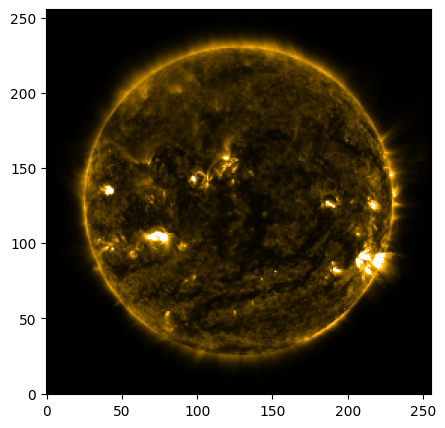

In [25]:
sub_image_eg = images_wanted_drry[0,:,:]
plt.figure(figsize=(5,5))
colormap = plt.get_cmap('sdoaia171')
plt.imshow(sub_image_eg,origin='lower',vmin=10,vmax=1000,cmap=colormap)

In [26]:
cache.cache.nbytes

{('array-getitem-4c9960cff0f008cca4f58c0f5c3c5e78', 0, 0): 1049088,
 ('getitem-4c9960cff0f008cca4f58c0f5c3c5e78', 0, 0): 1049088,
 ('array-getitem-cdc2f6838de65f753a800db52dd07b80', 0, 0): 262656,
 ('getitem-cdc2f6838de65f753a800db52dd07b80', 0, 0): 262656}

In [28]:
df = pd.read_csv("../../data/aia_image_data/images_df.csv")
df

,datetime,image_pixels_nparrayjson
0,2015-09-16 18:00:11.340000+00:00,"[[0.14696, 0.11772, 0.141, 0.16267, 0.2137, 0...."
1,2015-09-16 19:00:11.340000+00:00,"[[0.16167, 0.26291, 0.19186, 0.22529, 0.13309,..."
2,2015-09-16 20:00:11.340000+00:00,"[[0.05632, 0.16839, 0.23521, 0.22829, 0.04343,..."
3,2015-09-16 20:54:11.340000+00:00,"[[0.21464, 0.19139, 0.05171, 0.22339, 0.18738,..."
4,2015-09-16 22:00:11.340000+00:00,"[[0.19753, 0.34176, 0.16195, 0.24881, 0.28304,..."
5,2015-09-16 23:00:11.350000+00:00,"[[0.25251, 0.26157, 0.30035, 0.19145, 0.29498,..."
6,2015-09-20 00:00:11.340000+00:00,"[[0.10976, 0.06103, 0.16069, 0.06335, 0.16222,..."
7,2015-09-20 01:00:11.340000+00:00,"[[0.30739, 0.27115, 0.1824, 0.06161, 0.17948, ..."
8,2015-09-20 02:00:11.340000+00:00,"[[0.15639, 0.15824, 0.14833, 0.17903, 0.30437,..."
9,2015-09-20 03:00:11.340000+00:00,"[[0.14412, 0.08446, 0.23646, 0.33589, 0.22616,..."


In [27]:
# collect the wanted images to a csv

# HERE! save each image to a csv in a temp folder and use these csvs for skipping previously processed images

import pandas as pd
import json
import glob
import os

images_df_csv_path = "../../data/aia_image_data/images_df.csv"
images_temp_csvs_folder = "../../data/aia_image_data/temp_csvs"

# create images_df
images_temp_csvs = glob.glob(os.path.join(images_temp_csvs_folder, "*.csv"))
if len(images_temp_csvs) > 0:
    images_df = pd.concat([pd.read_csv(f) for f in images_temp_csvs], ignore_index=True)
else:
    images_df = pd.DataFrame(columns=["datetime", "image_pixels_nparrayjson"])

for image_time in images_wanted_times:
    current_img_time = str(image_time)

    # get the position of image_time in images_wanted_times
    image_time_idx = list(images_wanted_times).index(image_time)

    # check if the csv contains the row currently being processed and skip iter if true
    if current_img_time in images_df["datetime"].values:
        print(f"Skipping image_time_idx {image_time_idx} as it has been processed already.")
        continue
    
    # append current image to the csv
    image_arr = images_wanted_drry[image_time_idx, :, :].compute().round(5)
    image_pixels_nparrayjson = str([list(arr1d) for arr1d in list(image_arr)])
    images_df.loc[len(images_df)] = {
        "datetime": current_img_time,
        "image_pixels_nparrayjson": image_pixels_nparrayjson
    }
    # 

    # print progress
    print(f"image_time_idx: {image_time_idx} of {len(images_zry_wanted_idxs)}")
images_df.to_csv(images_df_csv_path, index=False)

images_df


Skipping image_time_idx 0 as it already exists in the csv
Skipping image_time_idx 1 as it already exists in the csv
Skipping image_time_idx 2 as it already exists in the csv
Skipping image_time_idx 3 as it already exists in the csv
Skipping image_time_idx 4 as it already exists in the csv
Skipping image_time_idx 5 as it already exists in the csv
Skipping image_time_idx 6 as it already exists in the csv
Skipping image_time_idx 7 as it already exists in the csv
Skipping image_time_idx 8 as it already exists in the csv
Skipping image_time_idx 9 as it already exists in the csv
Skipping image_time_idx 10 as it already exists in the csv
Skipping image_time_idx 11 as it already exists in the csv
Skipping image_time_idx 12 as it already exists in the csv
Skipping image_time_idx 13 as it already exists in the csv
Skipping image_time_idx 14 as it already exists in the csv
Skipping image_time_idx 15 as it already exists in the csv
Skipping image_time_idx 16 as it already exists in the csv
Skippin

KeyboardInterrupt: 

In [ ]:
images_df

In [ ]:
from io import StringIO

# df = pd.read_csv(StringIO(csvstr))
img_data = np.array(json.loads(images_df.iloc[0, 1]))
img_data

plt.figure(figsize=(5,5))
colormap = plt.get_cmap('sdoaia171')
plt.imshow(img_data,origin='lower',vmin=10,vmax=1000,cmap=colormap)

# plt.figure(figsize=(5,5))
# plt.imshow(sub_image_eg,origin='lower',vmin=10,vmax=1000,cmap=colormap)

In [ ]:
x = images_wanted_drry[0, :, :].compute().round(5)

[list(arr1d) for arr1d in list(x)]

In [ ]:
import pandas as pd
# from google.colab import drive

# drive.mount('/content/drive')
goes_events_2015 = pd.read_csv('/Users/aishwarya/gd/ML_project/code_repo/flare-finder/goes_events_clean_2015.csv')
goes_events_2015.head(10)

In [ ]:
type(images_df['datetime'][0])

In [ ]:
goes_events_2015['max_datetime'] = pd.to_datetime(goes_events_2015['max_datetime'], errors='coerce')

# Update the function to match only with max_datetime and handle NaN appropriately
def find_match_with_max_datetime(image_datetime, threshold=pd.Timedelta(hours=1)):  # Adjust the threshold as needed
    # Filter out rows where max_datetime is NaN
    valid_events = goes_events_2015.dropna(subset=['max_datetime'])
    
    if valid_events.empty:
        return np.nan  # Return NaN if no valid max_datetime exists

    # Calculate time differences only for valid max_datetime values
    time_diffs = valid_events['max_datetime'].apply(lambda x: abs(x - image_datetime))
    
    min_diff = time_diffs.min()  # Find the minimum time difference
    if min_diff <= threshold:
        return 1  # Match found within threshold
    else:
        return 0  # No match found within threshold

# Apply the updated function to each datetime in images_df
images_df['flare_flag'] = images_df['datetime'].apply(find_match_with_max_datetime)

images_df

In [ ]:
#count number of 1s in flare_flag
images_df['flare_flag'].value_counts()

In [ ]:
images_df

In [ ]:
np.shape(np.array(json.loads(images_df['image_pixels_np_str'][0])))

In [ ]:
# Create a 2D NumPy array
array = np.array([[1, 2], [3, 4]])

# Convert the array to a string
string = np.array_str(array)
print(string)
# Convert the string back to an array
new_array = np.fromstring(string)

# Print the original array and the new array
print(array)
print(new_array)

In [ ]:
np.fromstring(images_df['image_pixels_np_str'][0])

### 2d. Downsampling the data (temporally)

We can use pandas to downstample the data within a time-range. Here, we choose 1 day of observations at 12 minute frequency

In [ ]:
images_wanted_drry

In [ ]:
# selected_index is finding all the dates available in df_time['Time'] which is
# in the actual data and the hourly time_index that I've created in selected_times

selected_index = []
for selected_time_idx in wanted_times[None:None]:
  # print(i)
  selected_index.append(np.argmin(abs(df_time["Time"] - selected_time_idx)))
# may be a more efficient way of doing this
print('selected_index is: ', selected_index)

# keep only elements in selected_index that are greater than zero - but why?
images_zry_wanted_idxs = list(filter(lambda x: x > 0, selected_index))
print('time_index is: ', images_zry_wanted_idxs)

da.from_array(images_171a_zarray)[images_zry_wanted_idxs, :, :]

## 3. Generating a SunPy Map

SunPy is an open-source Python library for Solar Physics data analysis and visualization.

In this section we will demonstrate how SunPy’s [Map](https://docs.sunpy.org/en/stable/api/sunpy.map.Map.html#sunpy.map.Map) with the Zarr-formatted data. We demonstrate this for a single index.

In [ ]:
#lets try to get the dates associated with time_index
df_time["Time"][images_zry_wanted_idxs]

In [ ]:
# specify an image index -
# using the last time index
img_index = images_zry_wanted_idxs[-2]
print(img_index)

In [ ]:
# select the respective image, and header required for sunpy.map.Map()
selected_image = da.from_array(images_171a_zarray)[img_index, :, :]
selected_headr = {keys: values[img_index] for keys, values in images_171a_zarray.attrs.items()}

In [ ]:
type(images_171a_zarray)

In [ ]:
my_map = sunpy.map.Map((np.array(selected_image), selected_headr))

In [ ]:
plt.figure(figsize=(7, 7))
ax = plt.subplot(projection=my_map)
my_map.plot()

As this is then a SunPy Map object, we can manipulate it as such.

In [ ]:
my_map

For more information about SunPy, and Map, see the SunPy project: https://readthedocs.org/projects/sunpy/

## 4. Generating an AIA animation

In [ ]:
maps = []

for selected_time_idx in images_zry_wanted_idxs:
    selected_image = da.from_array(images_171a_zarray)[selected_time_idx, :, :]
    selected_headr = {keys: values[selected_time_idx] for keys, values in images_171a_zarray.attrs.items()}
    maps.append(sunpy.map.Map((np.array(selected_image), selected_headr)))

sq = sunpy.map.Map(maps, sequence=True, sortby="date")

In [ ]:
def animate_sequence(sequence, vmin = None, vmax = None):
    """
    An animation plotting routine to animate each element in MapSequence

    Parameters
    ----------
    sequence : `sunpy.map.mapsequence.MapSequence`
        a set of sunpy maps to animate

    Returns
    -------
    `matplotlib.animation.FuncAnimation`
        A FuncAnimation instance.
    """

    # fig, ax = plt.subplots(figsize=(7,7),
    #                       subplot_kw=dict(projection=sequence[0].wcs)
    #                      )

    ax = wcsaxes_compat.gca_wcs(sequence[0].wcs)
    fig = ax.get_figure()
    fig.figsize = (7, 7)

    plot_obj = sequence[0].plot(vmin = vmin, vmax = vmax)
    ax.set_title(sequence[0].latex_name)

    cbar = plt.colorbar()

    def update_fig(i):
        ax.set_title(sequence[i].latex_name)

        # set the data to that of the image being plot
        # Each image should be scaled as the first.
        plot_obj.set_data(sequence[i].data)

        # reset the WCS to that of the image being plot
        plot_obj.axes.reset_wcs(sequence[i].wcs)

        wcsaxes_compat.default_wcs_grid(ax)
        ax.set_xlabel(
            axis_labels_from_ctype(
                sequence[i].coordinate_system[0], sequence[i].spatial_units[0]
            )
        )
        ax.set_ylabel(
            axis_labels_from_ctype(
                sequence[i].coordinate_system[1], sequence[i].spatial_units[1]
            )
        )

        # basic test:
        # expect the wcs of the plot_obj to follow the sequence
        # print(sequence[i].wcs == plot_obj.axes.wcs, sequence[0].wcs == sequence[i].wcs)
        return (plot_obj,)

    anim = animation.FuncAnimation(
        fig, update_fig, init_func=None, frames=len(sequence), interval=60, repeat=True
    )
    plt.close(fig)

    return anim

In [ ]:
anim = animate_sequence(sq)
HTML(anim.to_jshtml())

## 5. Reading and loading HMI data

Now, we demonstrste how to read the HMI data within the SDOML dataset. In general, the HMI data structure is very similar to the AIA data. Instead of 9 AIA channels, for each time step, HMI has 3 channels that represent the 3 component of the vector magnetic field (i.e., Bx, By, and Bz). Using the same method described in section 2, we can load the HMI data in 2010:

In [ ]:
root = load_single_aws_zarr(
    path_to_zarr="s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_hmi_small.zarr/",
)
print(root.tree())

Same as AIA data, the new HMI data also includes all fits header information with the same keywords. To find out the HMI keyword definition, one can refer to the following online document:
http://jsoc.stanford.edu/doc/keywords/JSOC_Keywords_for_metadata.pdf

And one can list all the HMI keywords included:

In [ ]:
images_171a_zarray = root["2010"]["Bz"]
sorted(images_171a_zarray.attrs)

Note that the HMI keywords are slightly different comparing with AIA keywords. For example, there is no exposure time ('EXPTIME') in the HMI metadata. Also, the 'T_OBS' format is a bit different:

In [ ]:
t_obs = np.array(images_171a_zarray.attrs["T_OBS"])
t_obs

To keep it consistent with the AIA metadata, one can simply convert the time format:

In [ ]:
t_obs_new = []
for string in t_obs:
    new_string = string.replace('_TAI', 'Z')
    new_string = new_string.replace('_','T')
    new_string = new_string.replace('.','-')
    new_string = new_string.replace('Z', '.00')
    t_obs_new.append(new_string)
t = Time(t_obs_new, format='isot', scale='tai')
t_obs_new=t.value

Now we can load a magnetic map using Sunpy Map:

In [ ]:
da.from_array(images_171a_zarray)[0, :, :]

In [ ]:
selected_headr

In [ ]:
selected_image = da.from_array(images_171a_zarray)[0, :, :]
selected_headr = {keys: values[0] for keys, values in images_171a_zarray.attrs.items()}
selected_headr['WAVEUNIT'] = 'angstrom'
my_map = sunpy.map.Map((np.array(selected_image), selected_headr))
my_map

We can load a movie of HMI Bz component in the same time range as shown for AIA in the previous section:

In [ ]:
df_time = pd.DataFrame(t_obs_new, index=np.arange(np.shape(t_obs_new)[0]), columns=["Time"])
df_time["Time"] = pd.to_datetime(df_time["Time"])

# select times at a frequency of 12 minutes
wanted_times = pd.date_range(
    start="2010-08-28 00:00:00", end="2010-08-28 23:59:59", freq="12T")

selected_index = []
for selected_time_idx in wanted_times:
    selected_index.append(np.argmin(abs(df_time["Time"] - selected_time_idx)))

#mark the missing timestamps in the data
missing_index=np.where(abs(df_time['Time'][selected_index]-wanted_times)>pd.Timedelta('3m'))[0].tolist()
for selected_time_idx in missing_index:
    selected_index[selected_time_idx]=-1

# may be a more efficient way of doing this
images_zry_wanted_idxs = list(filter(lambda x: x > 0, selected_index))
da.from_array(images_171a_zarray)[images_zry_wanted_idxs, :, :]

In [ ]:
maps = []

for selected_time_idx in images_zry_wanted_idxs:
    selected_image = da.from_array(images_171a_zarray)[selected_time_idx, :, :]
    selected_headr = {keys: values[selected_time_idx] for keys, values in images_171a_zarray.attrs.items()}
    selected_headr['WAVEUNIT'] = 'angstrom'
    maps.append(sunpy.map.Map((np.array(selected_image), selected_headr)))

sq = sunpy.map.Map(maps, sequence=True, sortby="date")

In [ ]:
# The plot range can be specified by vmin and vmax
anim = animate_sequence(sq, vmin=-20, vmax=20)
HTML(anim.to_jshtml())

## 6. Reading and loading EVE data

The EVE data is timeseries data in 39 wavelengths from 2010 May 1 to 2014 May 26. The temporal resolution is 1 minute. In this section, we demonstrate how to read and load EVE data.

In [ ]:
root = load_single_aws_zarr(
    path_to_zarr="s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2_eve.zarr/",
)
print(root.tree())

As shown in the data structure tree, the ion line names can be identified. For some ions, there are multiple emission lines and the spectral line names end with '_1', '_2' to distinguish them. The details (e.g., ion, wavelength, emission temperature) are included in the metadata, which can be checked similar as AIA and HMI data:

In [ ]:
images_171a_zarray = root["MEGS-A"]["Fe XX"]
sorted(images_171a_zarray.attrs)

In [ ]:
images_171a_zarray.attrs['ion'],images_171a_zarray.attrs['wavelength'], images_171a_zarray.attrs['logT']

In addition, the 'Time' variable contains all timestamps of the data:

In [ ]:
time = root['MEGS-A']['Time']
time[0:10]

We can plot the spectral line timeseries data:

In [ ]:
df = pd.Series(images_171a_zarray,index=pd.to_datetime(time))
ax = df.plot(ylim=(0,2.e-4),figsize=(20,10),fontsize=20)
ax.set_title(str(images_171a_zarray.attrs['ion'])+' '+str(images_171a_zarray.attrs['wavelength'])+' LogT = '+str(images_171a_zarray.attrs['logT']),fontsize=20)
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Intensity [W/m^2]",fontsize=20)

----

This project was conducted during the 2018 NASA Frontier Development Lab (FDL) program, a public/private partnership between NASA and SETI and industry partners including NVIDIA Corporation, Lockheed Martin, and IBM. The authors thank IBM (especially Naeem Altaf) for generously providing computing resources on the IBM Cloud.